In [ ]:
!pip install pyshark

In [35]:
import pyshark
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import ipaddress

In [2]:
# Read the data
data = pd.read_csv("network_traffic_data.csv")

In [3]:
data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.1.6,224.0.0.251,MDNS,100,"Standard query 0x0000 PTR _rdlink._tcp.local, ..."
1,2,0.000000,fe80::18be:4bb4:1de5:77e3,ff02::fb,MDNS,120,"Standard query 0x0000 PTR _rdlink._tcp.local, ..."
2,3,3.843205,192.168.1.146,192.168.1.19,TCP,164,"62822 > 8009 [PSH, ACK] Seq=1 Ack=1 Win=1025..."
3,4,3.849903,192.168.1.19,192.168.1.146,TCP,164,"8009 > 62822 [PSH, ACK] Seq=1 Ack=111 Win=45..."
4,5,3.889950,192.168.1.146,192.168.1.19,TCP,54,62822 > 8009 [ACK] Seq=111 Ack=111 Win=1025 ...


In [4]:
# all the types of protocol
data["Protocol"].unique()

array(['MDNS', 'TCP', 'QUIC', 'TLSv1.2', 'ICMPv6', 'NTP', 'TLSv1.3',
       'DNS', 'AJP13', 'SSDP', 'UDP', 'ICMP', 'SSLv2'], dtype=object)

In [12]:
# check if emtpy data sample
data["Protocol"].isna().sum()

0

- MDNS (Multicast DNS): application layer protocol, Local network name resolution without needing a central DNS server
- TCP (Transmission Control Protocol): network & transport protocol, connection-oriented transport protocol
- QUIC (Quick UDP Internet Connections): develop by Google, runs on UDP but offers similar reliability and speed as TCP, used mainly by modern web applications lik google search, youtube, etc.
- TLS (Transport Layer Security): security & encryption protocol, used in HTTPS & emails
- ICMPv6 (ICMP for IPv6): network & transport protocol, ICMP equivalent for IPv6 networks, supports neighbor discovery/error messaging/more advanced IPv6 functions
- NTP (Network Time Protocol): network & transport protocol, synchronizes clocks of networked devices, essential for log consistency and scheduling
- DNS (Domain Name System): appliation layer protocol, resolves human-readable domain names (e.g., www.google.com) into IP addresses.
- AJP13 (Apache JServ Protocol version 1.3): application layer protocol, used by web servers to communicate with application servers, used in enterprise web applications
- SSDP (Simple Service Discovery Protocol): used in UPnP (Universal Plug and Play) for discovering devices on a local network (e.g., smart TVs, printers)
- UDP (User Datagram Protocol): network & transport protocol, connectionless transport protocol, used in streaming/DNS etc.
- ICMP (Internet Control Message Protocol): Used for sending error messages and operational information (e.g., ping, traceroute), does not carry data, only diagnostics.
- SSLv2 (Secure Sockets Layer v2): security & encryption protocol, replaced by newer versions like TLS
    

Since we are only interested on certain network traffic protocols used for browsing, streaming, etc., we will categorize these protocols.

In [13]:
# Network traffic categorization
protocols_map = {
    'TCP': 'Web Traffic',
    'TLSv1.2': 'Web Traffic',
    'TLSv1.3': 'Web Traffic',
    'SSLv2': 'Web Traffic',
    'QUIC': 'Streaming',
    'AJP13': 'Web Traffic',
    'UDP': 'Streaming',
    'DNS': 'DNS Traffic',
    'MDNS': 'DNS Traffic',
    'ICMP': 'Network Diagnostics',
    'ICMPv6': 'Network Diagnostics',
    'NTP': 'Network Diagnostics',
    'SSDP': 'Network Diagnostics'
}

# overview of the mapping
if 'Protocol' in data.columns:
    data['protocol_cat'] = data['Protocol'].map(protocols_map)

Now let's look at the distribution of the traffic data protocols.

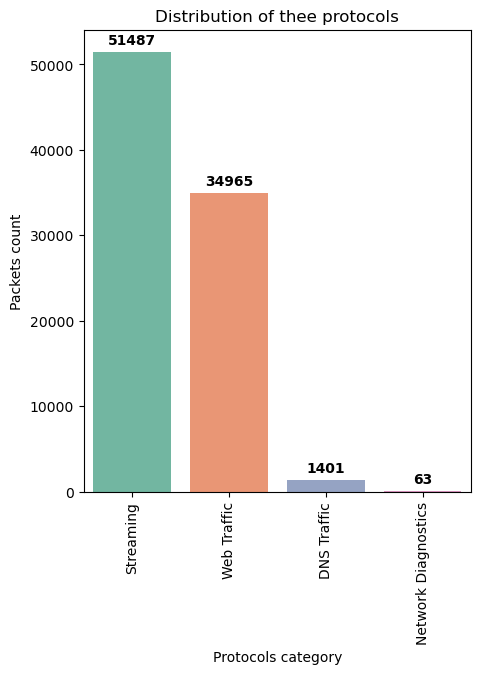

In [23]:
# Visualization of the distribution
plt.figure(figsize=(5, 6))
protocols_count = data['protocol_cat'].value_counts()
ax = sns.barplot(x=protocols_count.index, y=protocols_count.values, palette="Set2")

# Add counts on top of each bar
for i, v in enumerate(protocols_count.values):
    ax.text(i, v + max(protocols_count.values) * 0.01, str(v), ha='center', va='bottom', fontweight='bold')
    
plt.title("Distribution of thee protocols")
plt.xlabel("Protocols category")
plt.ylabel("Packets count")
plt.xticks(rotation=90)
plt.show()

In [24]:
# Drop irrelevant columns
data.drop(columns=["Info", "No."], inplace=True)

In [33]:
data.head()

,Time,Source,Destination,Protocol,Length,protocol_cat
0,0.000000,192.168.1.6,224.0.0.251,MDNS,100,DNS Traffic
1,0.000000,fe80::18be:4bb4:1de5:77e3,ff02::fb,MDNS,120,DNS Traffic
2,3.843205,192.168.1.146,192.168.1.19,TCP,164,Web Traffic
3,3.849903,192.168.1.19,192.168.1.146,TCP,164,Web Traffic
4,3.889950,192.168.1.146,192.168.1.19,TCP,54,Web Traffic


Since there are many sources in the traffic data, we will categorize them in some meaningful categories.

In [34]:
def categorize_source(ip):
    try:
        ip_obj = ipaddress.ip_address(ip)

        # Internal IP ranges
        if (
            ip_obj.is_private or
            ip_obj.is_link_local  # covers fe80::/10
        ):
            return 'Internal'

        # Google
        elif (
            ip.startswith('142.250.') or
            ip.startswith('2607:f8b0')
        ):
            return 'Google'

        # Microsoft
        elif (
            ip.startswith(('104.', '13.', '20.', '207.', '2603:', '2620:', '40.', '52.'))
        ):
            return 'Microsoft'

        # Amazon
        elif (
            ip.startswith(('3.', '18.', '34.', '44.', '54.', '108.')) or
            ip.startswith('2600:1f')
        ):
            return 'Amazon'

        # Cloudflare
        elif (
            ip.startswith('162.159') or
            ip.startswith('2606:4700')
        ):
            return 'Cloudflare'

        else:
            return 'Others'
    except ValueError:
        return 'Invalid IP'

In [36]:
# Apply the categorization
data['Source_Category'] = data['Source'].apply(categorize_source)

In [37]:
data['Source_Category'].unique()

array(['Internal', 'Microsoft', 'Others', 'Cloudflare', 'Amazon',
       'Google'], dtype=object)

In [39]:
data['Source_Category'].isna().sum()

0

In [ ]:
# Function to categorize sources
def categorize_source(ip):
    
    # Check for Internal (private IP ranges)
    if ip.startswith('192.168.') or ip.startswith('172.168.') or ip.startswith('fe80'):
        return 'Internal'
    
    # Check for Google
    elif ip.startswith('142.250.') or ip.startswith('2607:f8b0'):
        return 'Google'
    
    # Check for Microsoft
    elif ip.startswith('104.') or ip.startswith('13.') or ip.startswith('20.') or ip.startswith('207.') or ip.startswith('2603.') or ip.startswith('2620.') or ip.startswith('40.') or ip.startswith('52.'):
        return 'Microsoft'
    
    # Check for Amazon
    elif ip.startswith('18.') or ip.startswith('3.') or ip.startswith('34.') or ip.startswith('44.') or ip.startswith('54.'):
        return 'Amazon'
    
    # Check for Cloudflare
    elif ip.startswith('162.59') or ip.startswith('2606:4700'):
        return 'Cloudflare'.
    
    # Else category
    else:
        return 'Others'

In [28]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Source' column to get the encoded labels
data['source_encoded'] = label_encoder.fit_transform(data['Source']) + 1  # Starting from 1